In [1]:
import os
import numpy as np
import pandas as pd
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt
from datetime import datetime
from copy import deepcopy
# from torchviz import make_dot

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler

seed = 42
torch.manual_seed(1337)
# SIZE = 30
BATCH_SIZE = 5 # må bytte før "stor" trening
N_EPOCHS = 40

device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
class COBRE_dataset_subj(Dataset):
    """This Dataset class loads pairs of COBRE images and labels into the computer memory. The entire subject file is loaded.

    Parameters:
    - data_path (str): Path to the folder containing images and labels
    Returns:
    - Tensor: Torch tensor with COBRE time-series
    - int: label (0 or 1)

   """
    def __init__(self, data_path):
        self.data_path = data_path
        self.num_subjects = len(os.listdir(self.data_path))

    def __len__(self):
        return self.num_subjects

    def __getitem__(self, index):
        subject = os.listdir(self.data_path)[index]
        img = self.data_path + '/' + subject + '/nourest.nii'
        label = self.data_path + '/' + subject + '/' + subject + '_data.csv'

        img = nib.load(img).get_fdata()
        img = np.swapaxes(img, 0, 3)
        img = torch.from_numpy(img)
        img = img.to(torch.float)

        label = pd.read_csv(label)
        label = label.iloc[0]['subject_type']
        # covariates = df.iloc[0]['age', 'gender', 'handedness'].tolist()

        ### LABEL
        if label == 'Patient':
            label = 1
        elif label == 'Control':
            label = 0
        else:
            print('Something wrong with data label:', end=' ')
            print(label)
        
        ### AGE, GENDER AND HANDEDNESS
        # age = df.iloc[0]['age']
        # gender = df.iloc[0]['gender']
        # handedness = df.iloc[0]['handedness']

        # ### AGE
        # # age = (age - 18)/(65-18)

        # ### GENDER
        # if gender == 'Female':
        #     gender = 1
        # elif gender == 'Male':
        #     gender = 0
        # else:
        #     print('Something wrong with data label (gender):', end=' ')
        #     print(gender)

        # ### HANDEDNESS
        # if handedness == 'Right':
        #     handedness = [1,0]
        # elif handedness == 'Left':
        #     handedness = [0,1]
        # elif handedness == 'Both':
        #     handedness = [1,1]
        # else:
        #     print('Something wrong with data label (handedness):', end=' ')
        #     print(handedness)

        # covariates = [age, gender]
        # for h in handedness:
        #     covariates.append(h)
        
        # covariates = torch.Tensor(covariates)

        return img, label #, covariates

In [3]:
train_path = 'C:/Users/oscar/OneDrive - University of Bergen/Documents/Master/vsc/COBRE_learning/data/train'
val_path = 'C:/Users/oscar/OneDrive - University of Bergen/Documents/Master/vsc/COBRE_learning/data/val'

train_data = COBRE_dataset_subj(train_path)
val_data = COBRE_dataset_subj(val_path)

trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True) #, pin_memory=True, pin_memory_device=device)
valloader = DataLoader(val_data, batch_size=1, shuffle=False) #, pin_memory=True, pin_memory_device=device)

In [4]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv3d(150, 300, 5) #, padding=5)
#         self.pool = nn.MaxPool3d(2, 2)
#         self.conv2 = nn.Conv3d(300, 16, 5)
#         #self.fc1 = nn.LazyLinear(120)
#         self.fc1 = nn.Linear(16 * 2 * 2, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 17)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()
# net = net.to(device)
# criterion = nn.CrossEntropyLoss().to(device)
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [5]:
# ## Alternativ fra ChatGPT

# class SimpleCNN(nn.Module):
#     def __init__(self, num_classes):
#         super(SimpleCNN, self).__init__()
        
#         # Convolutional layers
#         self.conv1 = nn.Conv3d(in_channels=150, out_channels=50, kernel_size=(3, 3, 3), padding=1)
#         self.conv2 = nn.Conv3d(in_channels=50, out_channels=100, kernel_size=(3, 3, 3), padding=1)
#         self.conv3 = nn.Conv3d(in_channels=100, out_channels=150, kernel_size=(3, 3, 3), padding=1)
        
#         # Max pooling layer
#         self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=2)
        
#         # Fully connected layers
#         self.fc1 = nn.Linear(150 * 891, 512)  # Adjust the input size based on your spatial dimensions, 9 * 11 * 9
#         self.fc2 = nn.Linear(512, num_classes)
        
#         # Dropout layer to reduce overfitting
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
        
#         # Flatten the tensor before fully connected layers
#         x = x.view(-1, 150 * 891)  # Adjust the size based on your spatial dimensions
        
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
        
#         return x

# # Instantiate the model
# num_classes = 2  # Adjust based on the number of classes in your classification task
# net = SimpleCNN(num_classes)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [6]:
# ### med UNET som inspirasjon

# class UNET_inspired(nn.Module):
#     def __init__(self, num_classes, in_channels):
#         super(UNET_inspired, self).__init__()
        
#         # Convolutional layers
#         self.conv1 = (Conv_layer(in_channels, in_channels*2))
#         self.down1 = (Down(in_channels*2, in_channels*4))
#         self.down2 = (Down(in_channels*4, in_channels*8))
#         self.down3 = (Down(in_channels*8, in_channels*16))
#         self.pool = (nn.MaxPool3d(kernel_size=(2,2,2), stride=2))
#         self.fc1 = (nn.LazyLinear(num_classes))
        
#         # Dropout layer to reduce overfitting
#         self.dropout = nn.Dropout(0.5)

        
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.down1(x)
#         x = self.down2(x)
#         x = self.down3(x)
#         x = self.pool(x)
#         x = x.view(-1, 2400 * 80)
#         x = self.fc1(x)
#         return x


# class Conv_layer(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.conv = nn.Sequential(
#             nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3, 3), padding=1),
#             nn.BatchNorm3d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3, 3), padding=1),
#             nn.BatchNorm3d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.conv(x)
        
# class Down(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.pool_conv = nn.Sequential(
#             nn.MaxPool3d(kernel_size=(2, 2, 2)),
#             Conv_layer(in_channels, out_channels)
#         )

#     def forward(self, x):
#         return self.pool_conv(x)


# # Instantiate the model
# num_classes = 2  # Adjust based on the number of classes in your classification task
# unet = UNET_inspired(num_classes, 150)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(unet.parameters(), lr=0.001) #endre på denne for å få ned loss?

In [7]:
# ### SAVED, 77.777777
# ### med UNET som inspirasjon, med Mari sin hjelp
# ### kan ta inspirasjon fra denne: https://doi.org/gjj4xv

# class UNET_Mari(nn.Module):
#     def __init__(self, num_classes, in_channels):
#         super(UNET_Mari, self).__init__()
        
#         # Convolutional layers
#         self.conv1 = (nn.Conv3d(in_channels, 10, kernel_size=(3, 3, 3), padding=1))
#         self.conv1_2 = (nn.Conv3d(10, 1, kernel_size=(3, 3, 3), padding=1))
#         self.pool1 = (nn.MaxPool3d(kernel_size=(2,2,2), stride=2))
#         self.dropout = (nn.Dropout(0.5))
#         self.conv2 = (nn.Conv2d(47, 1, kernel_size=(3, 3), padding=1))
#         # also more layers here, perhaps
#         self.pool2 = (nn.MaxPool2d(kernel_size=(2,2), stride=2))
#         self.fc1 = (nn.Linear(19*19, 4*4)) # one functional layer or two?
#         self.fc2 = (nn.Linear(4*4, num_classes))

#     def forward(self, x): # should ReLU be used in every step here?
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv1_2(x))
#         x = self.dropout(x)
#         x = self.pool1(x)
#         x = torch.squeeze(x, dim=1)
#         x = F.relu(self.conv2(x))
#         x = self.dropout(x)
#         x = self.pool2(x)
#         x = torch.flatten(x, start_dim=1)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# # Instantiate the model
# num_classes = 2  # Adjust based on the number of classes in your classification task
# unet = UNET_Mari(num_classes, 150)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(unet.parameters(), lr=0.0001) #endre på lr for å få ned loss?

In [8]:
### 77.7777 modified
### med UNET som inspirasjon, med Mari sin hjelp
### kan ta inspirasjon fra denne: https://doi.org/gjj4xv

class UNET_Mari(nn.Module):
    def __init__(self, num_classes, in_channels):
        super(UNET_Mari, self).__init__()
        
        # Convolutional layers
        self.conv1 = (nn.Conv3d(in_channels, 10, kernel_size=(3, 3, 3), padding=1))
        self.conv1_2 = (nn.Conv3d(10, 1, kernel_size=(3, 3, 3), padding=1))
        self.pool1 = (nn.MaxPool3d(kernel_size=(2,2,2), stride=2))
        self.dropout = (nn.Dropout(0.2))
        self.conv2 = (nn.Conv2d(47, 1, kernel_size=(3, 3), padding=1))
        # also more layers here, perhaps
        self.pool2 = (nn.MaxPool2d(kernel_size=(2,2), stride=2))
        self.fc1 = (nn.Linear(19*19, 4*4)) # one functional layer or two?
        self.fc2 = (nn.Linear(4*4, num_classes))

    def forward(self, x): # should ReLU be used in every step here?
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv1_2(x))
        x = self.dropout(x)
        x = self.pool1(x)
        x = torch.squeeze(x, dim=1)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool2(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
num_classes = 2  # Adjust based on the number of classes in your classification task
unet = UNET_Mari(num_classes, 150)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr=0.0001) #endre på lr for å få ned loss?

In [9]:
# batch = next(iter(trainloader))[0]
# batch = batch.to(device)
# net = net.to(device)
# yhat = net(batch) # Give dummy batch to forward().
# make_dot(yhat, params=dict(list(net.named_parameters()))).render("rnn_torchviz", format="png")

In [10]:
unet = unet.to(device)
losses_train = []
losses_val = []
correct = 0
total = 0
best_acc_val = 0
n_batch_train = len(trainloader)
n_batch_val = len(valloader)

for epoch in range(1,N_EPOCHS+1,1):  # loop over the dataset multiple times
    ### TRAINING PHASE
    loss_train = 0
    # running_loss = 0.0
    unet.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0], data[1]
        # labels = labels.type(torch.LongTensor)   # casting to long
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        # running_loss += loss.item()
        loss_train += loss.item()
        # if i % 5 == 4:    # print every 2 mini-batches CHANGE THIS FOR MORE INFO DURING TRAINING
        #     print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 10:.3f}')
        #     running_loss = 0.0
    losses_train.append(loss_train/n_batch_train)

    ### VALIDATION PHASE
    correct = 0
    total = 0
    loss_val = 0
    unet.eval()
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            inputs, labels = data[0], data[1]
            # labels = labels.type(torch.LongTensor)   # casting to long
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = unet(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            # _, predicted = torch.max(outputs.data, 1)
            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()
            # for i in range(len(predicted)):
            #     pred.append(predicted[i].item())
            #     true.append(labels[i].item())

            loss = criterion(outputs, labels)
            loss_val += loss.item()
    losses_val.append(loss_val/n_batch_val)

    current_acc_val = 100 * correct / total

    print('{}  |  Epoch {}/{}  |  Training loss {:.9f} |  Validation loss {:.9f} | Validation accuracy {:.3f}'.format(
                datetime.now().time(), epoch, N_EPOCHS, loss_train / n_batch_train, loss_val/n_batch_val, current_acc_val))
    
    if(current_acc_val > best_acc_val):
        # torch.save(unet.state_dict().copy(), 'models/best_model_params_nou.pt')
        best_params = deepcopy(unet.state_dict())
        torch.save(best_params, 'models/best_model_params_nou.pt')
        # torch.save(unet, 'models/best_model_nou.pt')
        print('New best acc:', current_acc_val, end='  ------  ')
        print('Old acc:' , best_acc_val)
        best_acc_val = current_acc_val

print('Finished Training')

21:34:47.683856  |  Epoch 1/5  |  Training loss 0.929061247 |  Validation loss 0.645760713 | Validation accuracy 55.556
New best acc: 55.55555555555556  ------  Old acc: 0
21:36:10.064622  |  Epoch 2/5  |  Training loss 0.694555825 |  Validation loss 0.606240009 | Validation accuracy 72.222
New best acc: 72.22222222222223  ------  Old acc: 55.55555555555556
21:37:32.218370  |  Epoch 3/5  |  Training loss 0.681879577 |  Validation loss 0.620631081 | Validation accuracy 72.222
21:38:55.128463  |  Epoch 4/5  |  Training loss 0.679724208 |  Validation loss 0.611408290 | Validation accuracy 77.778
New best acc: 77.77777777777777  ------  Old acc: 72.22222222222223
21:40:17.780569  |  Epoch 5/5  |  Training loss 0.661940858 |  Validation loss 0.604113224 | Validation accuracy 77.778
Finished Training


In [11]:
print(best_acc_val)
best_model = UNET_Mari(num_classes, 150)
# best_model.load_state_dict(torch.load('models/best_model_params_nou.pt'))
best_model.load_state_dict(best_params)
best_model.to(device)

correct = 0
total = 0
y_pred = []
y_true = []
# since we're not training, we don't need to calculate the gradients for our outputs
best_model.eval()
with torch.no_grad():
    for data in valloader:
        inputs, labels= data[0], data[1]
        # labels = labels.type(torch.LongTensor)   # casting to long
        inputs, labels= inputs.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = best_model(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(len(predicted)):
            y_pred.append(predicted[i].item())
            y_true.append(labels[i].item())

print(f'Accuracy of the network on the val images: {100 * correct / total} %')

77.77777777777777
Accuracy of the network on the val images: 77.77777777777777 %


In [12]:
correct_train = 0
total_train = 0
y_pred_train = []
y_true_train = []
# since we're not training, we don't need to calculate the gradients for our outputs
best_model.eval()
with torch.no_grad():
    for data in trainloader:
        inputs, labels= data[0], data[1]
        # labels = labels.type(torch.LongTensor)   # casting to long
        inputs, labels= inputs.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = best_model(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        for i in range(len(predicted)):
            y_pred_train.append(predicted[i].item())
            y_true_train.append(labels[i].item())

print(f'Accuracy of the network on the train images: {100 * correct_train / total_train} %')

Accuracy of the network on the train images: 63.46153846153846 %


In [13]:
print('Val')
print('F1-score:', f1_score(y_true, y_pred, average="weighted")*100)
print('Balanced accuracy score:', balanced_accuracy_score(y_true, y_pred)*100)
print()
print('Train')
print('F1-score:', f1_score(y_true_train, y_pred_train, average="weighted")*100)
print('Balanced accuracy score:', balanced_accuracy_score(y_true_train, y_pred_train)*100)

Val
F1-score: 77.49999999999999
Balanced accuracy score: 77.77777777777777

Train
F1-score: 63.12056737588653
Balanced accuracy score: 63.46153846153846


In [38]:
print('Val')
print('True:', y_true)
print('Pred:', y_pred)
print(np.unique([t==y for t,y in zip(y_true, y_pred)], return_counts=True))
print()
print('Train')
print('True:', y_true_train)
print('Pred:', y_pred_train)
print(np.unique([t==y for t,y in zip(y_true_train, y_pred_train)], return_counts=True))

Val
True: [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
Pred: [0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
(array([False,  True]), array([ 4, 14], dtype=int64))

Train
True: [1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
Pred: [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
(array([False,  True]), array([38, 66], dtype=int64))


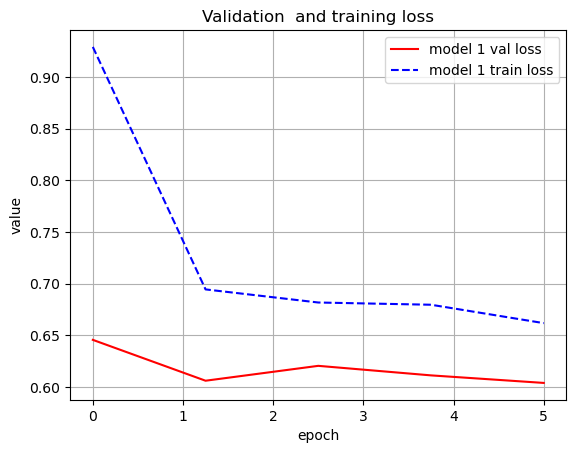

In [15]:
validation_losses = torch.Tensor([losses_val], device='cpu')
train_losses = torch.Tensor([losses_train], device='cpu')
colors = ['r', 'b', 'g']

for i in range(len(validation_losses)):
    xvalues = np.linspace(0, N_EPOCHS, len(validation_losses[i]))
    yvalues01 = validation_losses[i]
    yvalues02 = train_losses[i]
    name = "model %i "%(i+1)

    plt.plot(xvalues, yvalues01, label=name + "val loss", color='r')
    plt.plot(xvalues, yvalues02, label=name + "train loss", color='b', linestyle="dashed")

plt.title('Validation  and training loss')
plt.xlabel('epoch')
plt.ylabel('value')
plt.grid(True)
plt.legend()
plt.show()